## Distance of trans-eQTLs from the human TFs

 - How far are the trans-eQTLs from known transcription factors?
 - How does it compare to some randomly selected SNPs from the data?

In [32]:
resdir = "/usr/users/sbanerj/trans_eqtl_results/gtex_v8_tejaas_permnull_sb0.1_knn"
tissue_file = "../tissue_table.txt"
rrfile = "trans_eqtls.txt"
tffile = "../external/human_TF_annotation_gencode_v26.txt"
pcgenefile = "../external/human_protein_coding_genes_gencode_v26.txt"
chrmlist = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
Nrand = 50000
cis_window = 0.0 # (in Mb)

snpdir = '/usr/users/sbanerj/gtex_v8/genotype/all_samples/'
gtfile_fmt = 'GTEX_v8_2019-07-29_WGS_838Indiv_Freeze_NoMissingGT_SNPfilter_MAF0.01_withDS_chr{:d}.snplist'
json_file = "../external/gtex_metadata.json"

In [27]:
import numpy as np
import collections
import os
import time
import math
import json

import matplotlib.pyplot as plt
#plt.switch_backend('agg')
import matplotlib
import sys
sys.path.append('../')
from utils import utils
from utils import mpl_stylesheet
from utils import read_tejaas_results
mpl_stylesheet.banskt_presentation(fontfamily = 'latex-clearsans', fontsize = 22, colors = 'banskt', dpi = 72)

In [3]:
GENEINFO_FIELDS = ['name', 'ensembl_id', 'chrom', 'start', 'end']
class GeneInfo(collections.namedtuple('_GeneInfo', GENEINFO_FIELDS)):
    __slots__ = ()

tflist = list()
with open(pcgenefile, 'r') as instream:
    next(instream)
    for line in instream:
        linesplit = line.strip().split()
        ensembl = linesplit[0]
        chrom = int(linesplit[1])
        start = int(linesplit[2])
        end = int(linesplit[3])
        name = linesplit[4]
        tflist.append(GeneInfo(name = name, ensembl_id = ensembl, chrom = chrom, start = start, end = end))

In [5]:
def find_minimum_distance(spos, starts, ends):
    diffs = zip([spos - x for x in starts], [spos - x for x in ends])
    dists = np.array([math.copysign(min(abs(a), abs(b)), a) if a * b > 0 else 0 for a, b in diffs])
    return dists[np.argmin(np.abs(dists))]

def find_minimum_distance_from_start(spos, starts):
    dists = np.array([spos - x for x in starts])
    return dists[np.argmin(np.abs(dists))]

#### Randomly selected SNPs

Select `Nrand` random SNPs, and find the distance of their nearest transcription factors. The distribution of these distances `mindist_rand` would serve as a background.

To check enrichment, we select 1000 SNPs and check the distance enrichment multiple times. 

In [21]:
snppos = dict()
for chrm in range(1, 23):
    fname = os.path.join(snpdir, gtfile_fmt.format(chrm))
    with open (fname, 'r') as instream:
        first = next(instream).strip().split()[0]
        for line in instream:
            pass
        last = line.strip().split()[0]
    firstpos = int(first.split('_')[1])
    lastpos = int(last.split('_')[1])
    snppos[chrm] = list([firstpos, lastpos])

In [22]:
def random_mindist(Nrand, snppos, chrmlist):
    mindist_rand = list()
    ratios = np.random.rand(len(chrmlist))
    ndraws = [int(x) for x in np.around(Nrand * ratios / np.sum(ratios))]
    for i, chrm in enumerate(chrmlist):
        N = ndraws[i]
        firstpos = snppos[chrm][0]
        lastpos  = snppos[chrm][1]
        rands = firstpos + np.random.rand(N) * (lastpos - firstpos)
        selects = np.sort([int(x) for x in rands])
        tfchrmlist = [x for x in tflist if x.chrom == chrm]
        tfstarts = [x.start for x in tflist if x.chrom == chrm]
        tfends = [x.end for x in tflist if x.chrom == chrm]
        for spos in selects:
            xmin = find_minimum_distance(spos, tfstarts, tfends)
            mindist_rand.append(xmin / 1e6)
    mindist_rand = np.array(mindist_rand)
    return mindist_rand

In [33]:
Niter = 10
tf_frac_rand = 0
for i in range(Niter):
    mindist_rand = random_mindist(Nrand, snppos, chrmlist)
    this_tf_frac = np.sum(np.abs(mindist_rand) <= cis_window) / mindist_rand.shape[0]
    print(f'Iteration {i}. Fraction of SNPs with cis TFs = {this_tf_frac}')
    tf_frac_rand += this_tf_frac
tf_frac_rand /= Niter

print(f'Fraction of cis TFs for randomly selected SNPs: {tf_frac_rand :7.4f}')

Iteration 0. Fraction of SNPs with cis TFs = 0.45376
Iteration 1. Fraction of SNPs with cis TFs = 0.43220864417288346
Iteration 2. Fraction of SNPs with cis TFs = 0.4260114797704046
Iteration 3. Fraction of SNPs with cis TFs = 0.4369487389747795
Iteration 4. Fraction of SNPs with cis TFs = 0.4438
Iteration 5. Fraction of SNPs with cis TFs = 0.4360174406976279
Iteration 6. Fraction of SNPs with cis TFs = 0.4369462167730064
Iteration 7. Fraction of SNPs with cis TFs = 0.44207115857682844
Iteration 8. Fraction of SNPs with cis TFs = 0.43603383796972184
Iteration 9. Fraction of SNPs with cis TFs = 0.4376487529750595
Fraction of cis TFs for randomly selected SNPs:  0.4381


In [19]:
Niter = 1000
Ncheck = 1000

enrichment_rand = list()
for i in range(Niter):
    if i % 100 == 0:
        print(f'Iteration {i}')
    tfdist_rand = random_mindist(Ncheck, snppos, chrmlist)
    this_tf_frac = np.where(np.abs(tfdist_rand) <= cis_window)[0].shape[0] / Ncheck
    this_tf_enrichment = this_tf_frac / tf_frac_rand
    enrichment_rand.append(this_tf_enrichment)
    
enrichment_rand = np.array(enrichment_rand)

Iteration 0
Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 500
Iteration 600
Iteration 700
Iteration 800
Iteration 900


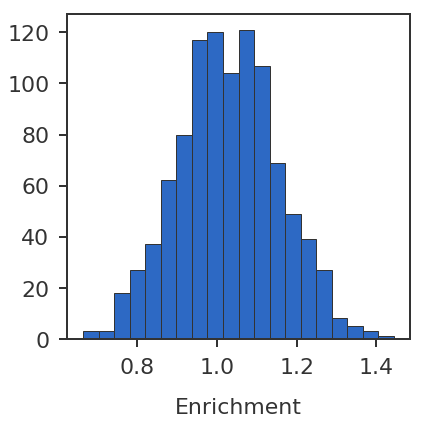

In [20]:
fig = plt.figure(figsize = (6, 6))
ax1 = fig.add_subplot(111)

ax1.hist(enrichment_rand)
ax1.set_xlabel('Enrichment')
plt.tight_layout()
plt.show()

#### Trans-eQTLs discovered by TEJAAS

In [6]:
tshorts, tfulls = utils.read_tissues(tissue_file)
with open(json_file) as instream:
    gtex_meta = json.load(instream)
tissue_colors = dict()
tissue_names = dict()
for tshort, tfull in zip(tshorts, tfulls):
    tissue_names[tshort] = tfull
    tissue_colors[tshort] = "#" + gtex_meta[tfull.replace(" ", "_")]["colorHex"]

In [9]:
transeqtls = dict()

for tissue in tshorts:
    filename = os.path.join(resdir, tissue, rrfile)
    if os.path.isfile(filename):
        transeqtls[tissue] = read_tejaas_results.transeqtls(filename)
        print(f'{tissue}: {len(transeqtls[tissue])} trans-eQTLs')
    else:
        print(f'{tissue}: Result file not found.')

SNPs with zero p-value: 23
as: 1646 trans-eQTLs
av: 514 trans-eQTLs
SNPs with zero p-value: 16
ag: 281 trans-eQTLs
SNPs with zero p-value: 126
aa: 3999 trans-eQTLs
SNPs with zero p-value: 48
ac: 3396 trans-eQTLs
at: 1068 trans-eQTLs
SNPs with zero p-value: 246
bam: 5139 trans-eQTLs
SNPs with zero p-value: 230
ban: 2842 trans-eQTLs
SNPs with zero p-value: 37
bca: 56 trans-eQTLs
SNPs with zero p-value: 42
bceh: 475 trans-eQTLs
SNPs with zero p-value: 25
bce: 57 trans-eQTLs
SNPs with zero p-value: 32
bco: 160 trans-eQTLs
SNPs with zero p-value: 45
bfr: 90 trans-eQTLs
SNPs with zero p-value: 69
bhi: 295 trans-eQTLs
SNPs with zero p-value: 136
bhy: 781 trans-eQTLs
SNPs with zero p-value: 53
bnu: 921 trans-eQTLs
SNPs with zero p-value: 67
bpu: 74 trans-eQTLs
SNPs with zero p-value: 178
bsp: 338 trans-eQTLs
SNPs with zero p-value: 150
bsu: 175 trans-eQTLs
br: 812 trans-eQTLs
SNPs with zero p-value: 30
ebv: 396 trans-eQTLs
cols: 55 trans-eQTLs
SNPs with zero p-value: 9
colt: 2310 trans-eQTLs
S

#### Add the eQTLgen results

In [58]:
eqtlgen_resfile = '/scratch/sbanerj/from_franco/EQTLgen/eqtlgen_signif_SNPs_uniq_rsid_chr_pos.txt'

if not 'eqtlgen' in tshorts:
    tshorts += ['eqtlgen']
    tfulls += ['EQTLGen']
    transeqtls['eqtlgen'] = list()

    with open(eqtlgen_resfile, 'r') as infile:
        for line in infile:
            linesplit = line.strip().split()
            chrm = int(linesplit[1].strip())
            pos = int(linesplit[2].strip())
            varid = f'chr{chrm}_{pos}_eqtlgen'
            thisres = EqtlInfo(chrom = chrm, varid = varid, bp_pos = pos, pval = 5e-8, log10pval = -np.log10(5e-8))
            transeqtls['eqtlgen'].append(thisres)

    tissue_names['eqtlgen'] = 'EQTLGen'
    tissue_colors['eqtlgen'] = 'gray'

In [10]:
mindist = dict()

tfstarts = dict()
tfends = dict()
for chrm in chrmlist:
    tfstarts[chrm] = [x.start for x in tflist if x.chrom == chrm]
    tfends[chrm] = [x.end for x in tflist if x.chrom == chrm]    

for tissue, teqtllist in transeqtls.items():
    mindist[tissue] = list()
    for teqtl in teqtllist:
        chrm = teqtl.chrom
        spos = teqtl.bp_pos
        xmin = find_minimum_distance(spos, tfstarts[chrm], tfends[chrm])
        mindist[tissue].append(xmin / 1e6)

In [25]:
cisgenes = [np.sum(np.abs(x) <= 0.0) / len(x) / tf_frac_rand for key, x in mindist.items() if len(x) > 0] 

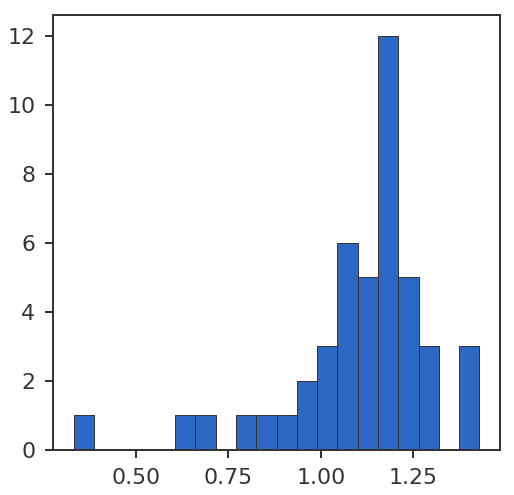

In [28]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(cisgenes)
plt.show()

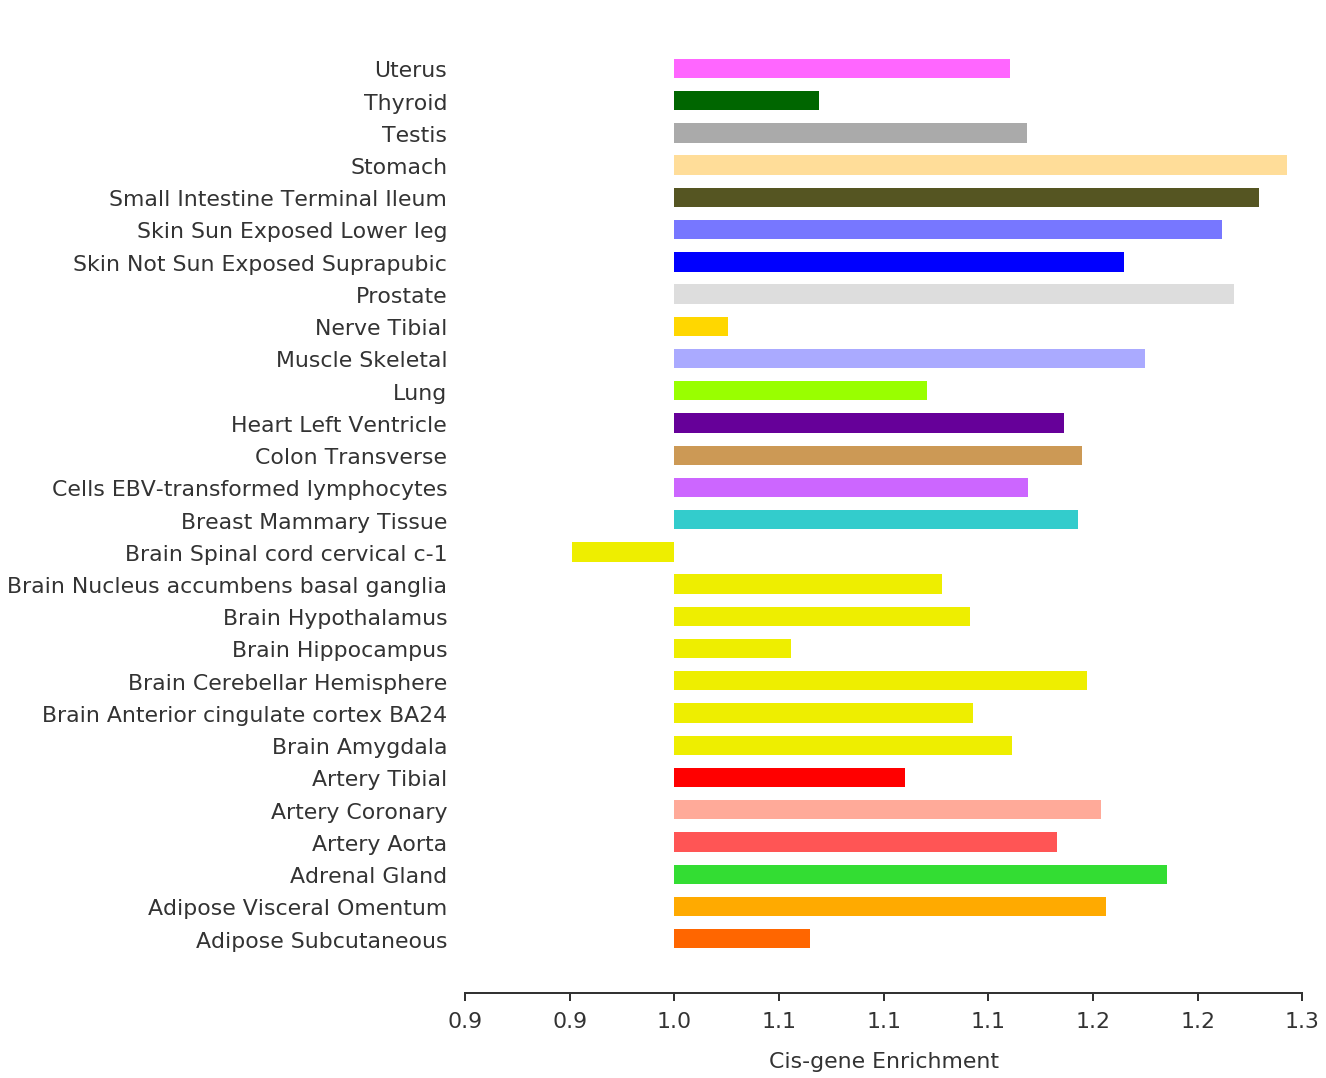

In [31]:
objects = list()
performance = list()
significance = list()
bar_colors = list()

plot_tissues = [t for t, _ in mindist.items()]

for tshort in tshorts:
    if tshort in plot_tissues:
        nteqtl = len(transeqtls[tshort])
        if nteqtl >= 200:
        #if nteqtl < 200:            
            if nteqtl == 0:
                objects.append(tissue_names[tshort])
                performance.append(0)
                significance.append('')
            else:            
                tf_frac_tissue = len([x for x in mindist[tshort] if abs(x) <= cis_window]) / nteqtl
                tf_enrichment = tf_frac_tissue / tf_frac_rand
                #tf_enrichment_pval = (np.sum(enrichment_rand >= tf_enrichment) + 1) / (enrichment_rand.shape[0] + 1)

                objects.append(tissue_names[tshort])
                performance.append(tf_enrichment - 1.0)
                #if tf_enrichment_pval <= 0.001:
                #    significance.append('***')
                #elif tf_enrichment_pval <= 0.01:
                #    significance.append('**')
                #elif tf_enrichment_pval <= 0.05:
                #    significance.append('*')
                #else:
                #    significance.append('')
                significance.append('')
            bar_colors.append(tissue_colors[tshort])

        

fig = plt.figure(figsize = (15, 18))
ax1 = fig.add_subplot(111)

y_pos = np.arange(len(objects))
bar1 = ax1.barh(y_pos, performance, align='center', color = bar_colors, linewidth = 0, height = 0.6)

ax1.set_yticks(y_pos)
ax1.set_yticklabels(objects)
ax1.set_xlabel('Cis-gene Enrichment')
xmax = np.around(np.max(performance) + 0.05, decimals = 1)
xmin = np.around(np.min(performance) - 0.05, decimals = 1)
ax1.set_xlim([xmin, xmax])

ax1.tick_params(bottom = True, top = False, left = False, right = False, labelleft = True, labelbottom = True)
for side, border in ax1.spines.items():
    if not side == 'bottom':
        border.set_visible(False)
        
# Add p-values beside the bars
for i, rect in enumerate(bar1):
    width = rect.get_width()
    xpos = rect.get_width() + 0.02
    ypos = rect.get_y() + rect.get_height() / 2.0
    ax1.text(xpos, ypos, f'{significance[i]}', ha='left', va='center')

fig.canvas.draw()
xticklabels = [f'{x.get_position()[0] + 1 :3.1f}' for x in ax1.get_xticklabels()]
ax1.set_xticklabels(xticklabels)

#outfile = "../plots/tf_enrichment_100kb.png"
#plt.savefig(outfile, bbox_inches='tight')
plt.show()